In [1]:
# Mount Google Drive to access your dataset (optional if uploading directly)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install Detectron2 from source
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e .

# Import Detectron2 and set up logger after installation
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import os
import json
import shutil

fatal: destination path 'detectron2' already exists and is not an empty directory.
/content/detectron2
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [16]:
# Define dataset paths (using Drive)
dataset_dir = "/content/drive/MyDrive/Retinanetcoco_dataset"

# Preprocess JSON to filter out unwanted categories
def filter_coco_json(input_path, output_path, keep_categories=[1, 2]):  # Keep only Boulder (1) and Crater (2)
    with open(input_path, "r") as f:
        data = json.load(f)

    # Filter categories to keep only Boulder and Crater
    filtered_categories = [cat for cat in data["categories"] if cat["id"] in keep_categories]
    # Remap category IDs to start from 0 (1 -> 0 for Boulder, 2 -> 1 for Crater)
    for i, cat in enumerate(filtered_categories):
        cat["id"] = i  # Reassign IDs: Boulder becomes 0, Crater becomes 1

    # Create a mapping for original IDs to new IDs
    category_id_map = {1: 0, 2: 1}  # Original 1 -> 0, 2 -> 1

    # Filter annotations to keep only those with Boulder or Crater
    filtered_annotations = [ann for ann in data["annotations"] if ann["category_id"] in keep_categories]
    # Remap the category_id in annotations
    for ann in filtered_annotations:
        ann["category_id"] = category_id_map[ann["category_id"]]

    # Update data with filtered lists
    data["categories"] = filtered_categories
    data["annotations"] = filtered_annotations

    # Save the filtered JSON
    with open(output_path, "w") as f:
        json.dump(data, f, indent=2)

    # Debug: Print category and annotation counts
    print(f"Processed {input_path}:")
    print(f"Categories: {len(filtered_categories)} - {filtered_categories}")
    print(f"Annotations: {len(filtered_annotations)}")

# Process each split (train, valid, test)
for split in ["train", "valid", "test"]:
    input_json = os.path.join(dataset_dir, split, "_annotations.coco.json")
    output_json = os.path.join(dataset_dir, split, "_annotations_filtered.coco.json")
    filter_coco_json(input_json, output_json)

Processed /content/drive/MyDrive/Retinanetcoco_dataset/train/_annotations.coco.json:
Categories: 2 - [{'id': 0, 'name': 'Boulder', 'supercategory': 'craters_boulders'}, {'id': 1, 'name': 'Crater', 'supercategory': 'craters_boulders'}]
Annotations: 1574
Processed /content/drive/MyDrive/Retinanetcoco_dataset/valid/_annotations.coco.json:
Categories: 2 - [{'id': 0, 'name': 'Boulder', 'supercategory': 'craters_boulders'}, {'id': 1, 'name': 'Crater', 'supercategory': 'craters_boulders'}]
Annotations: 471
Processed /content/drive/MyDrive/Retinanetcoco_dataset/test/_annotations.coco.json:
Categories: 2 - [{'id': 0, 'name': 'Boulder', 'supercategory': 'craters_boulders'}, {'id': 1, 'name': 'Crater', 'supercategory': 'craters_boulders'}]
Annotations: 229


In [18]:
# Register the filtered dataset
from detectron2.data.datasets import register_coco_instances

# Clear DatasetCatalog and remove specific MetadataCatalog entries
DatasetCatalog.clear()
for split in ["train", "valid", "test"]:
    dataset_name = f"lunar_{split}"
    if dataset_name in MetadataCatalog:
        MetadataCatalog.remove(dataset_name)

for split in ["train", "valid", "test"]:
    register_coco_instances(
        f"lunar_{split}",
        {},  # Empty metadata dict
        os.path.join(dataset_dir, split, "_annotations_filtered.coco.json"),
        os.path.join(dataset_dir, split)
    )
    MetadataCatalog.get(f"lunar_{split}").set(thing_classes=["Boulder", "Crater"])

In [21]:
# Configure RetinaNet
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("lunar_train",)
cfg.DATASETS.TEST = ("lunar_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2  # Adjust based on GPU memory
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000  # Suitable for ~70 images, adjust if needed
cfg.MODEL.RETINANET.NUM_CLASSES = 2  # Set number of classes for RetinaNet
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

# Output directory
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Debug: Confirm configuration
print("Model config NUM_CLASSES:", cfg.MODEL.RETINANET.NUM_CLASSES)

Model config NUM_CLASSES: 2


In [26]:
import pickle
from detectron2.engine import HookBase
from detectron2.utils.events import get_event_storage

class HistoryHook(HookBase):
    def __init__(self, output_dir):
        self.output_dir = output_dir

    def after_train(self):
        storage = get_event_storage()
        history = {
            "total_loss": storage.histories()["total_loss"]._data,
            "loss_cls": storage.histories()["loss_cls"]._data,
            "loss_box_reg": storage.histories()["loss_box_reg"]._data,
            "lr": storage.histories()["lr"]._data,
            "iter": list(range(0, self.trainer.max_iter, 20))
        }
        with open(os.path.join(self.output_dir, "training_history.pkl"), "wb") as f:
            pickle.dump(history, f)
        print("Training history saved to:", os.path.join(self.output_dir, "training_history.pkl"))

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluation")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.append(HistoryHook(self.cfg.OUTPUT_DIR))
        return hooks

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/06 16:50:45 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[04/06 17:02:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
WARNING [04/06 17:02:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/06 17:02:13 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/drive/MyDrive/Retinanetcoco_dataset/valid/_annotations_filtered.coco.json
Image: /content/drive/MyDrive/Retinanetcoco_dataset/valid/frame100_jpg.rf.5d15edb3eedc6b129dadc9594104173e.jpg
Predicted classes: [0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction scores: [0.9930912  0.9753882  0.9734213  0.96153665 0.95886827 0.9504994
 0.9413657  0.9397353  0.9346046  0.9188234  0.9109674  0.9091833
 0.9053746  0.90432525 0.8956424  0.8635623  0.8582455  0.84149855
 0.8385108  0.7801242  0.7012514  0.69323105 0.6915013  0.6886078
 0.684481   0.63846123 0.63246316 0.6195459  0.60401124 0.58968866
 0.5378804  0.5303975  0.50

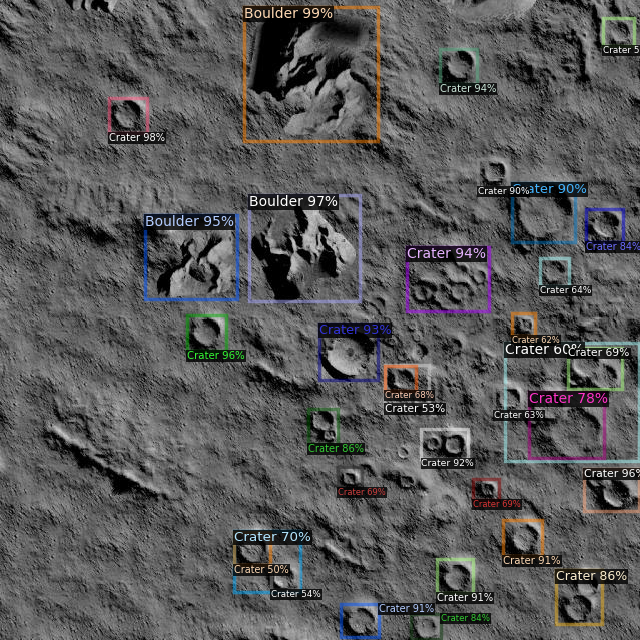

Image: /content/drive/MyDrive/Retinanetcoco_dataset/valid/frame1055_jpg.rf.ec7604e6908d8244cd59c1ffbf7823b7.jpg
Predicted classes: [0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0]
Prediction scores: [0.99449325 0.989228   0.9830967  0.9779058  0.9728941  0.9704287
 0.95794135 0.9524168  0.944545   0.9438325  0.943374   0.94253325
 0.88189256 0.84722346 0.8203096  0.7669204  0.7474644  0.66466784
 0.63800293 0.60532945 0.5716233  0.5704758  0.56193507 0.53805345
 0.53676003 0.50615853]


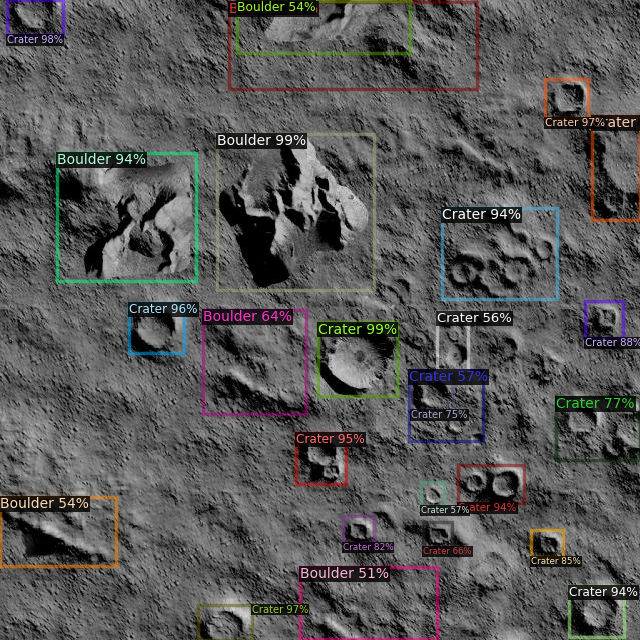

Image: /content/drive/MyDrive/Retinanetcoco_dataset/valid/frame1067_jpg.rf.d5b1d0fb38f2ade92f02838251329945.jpg
Predicted classes: [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0]
Prediction scores: [0.99481285 0.99326247 0.9812151  0.97477573 0.96913046 0.96081644
 0.95425105 0.9384893  0.9378497  0.9332078  0.93086404 0.90131307
 0.86232144 0.8397819  0.8105143  0.75009006 0.72932774 0.67700917
 0.6387128  0.6198676  0.6038547  0.55598325 0.55268776 0.51760817]


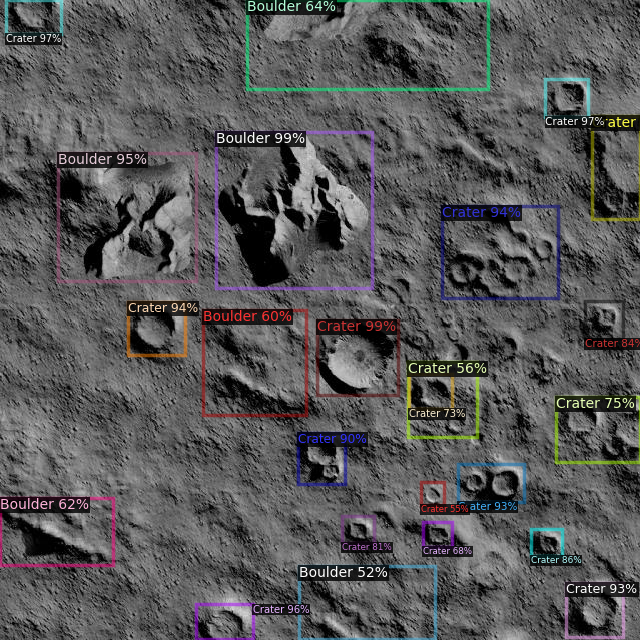

In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import Visualizer
import cv2
import random
from google.colab.patches import cv2_imshow

dataset_dicts = DatasetCatalog.get("lunar_valid")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(os.path.join(dataset_dir, "valid", d["file_name"]))
    outputs = predictor(img)
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()
    pred_scores = outputs["instances"].scores.cpu().numpy()
    print(f"Image: {d['file_name']}")
    print(f"Predicted classes: {pred_classes}")
    print(f"Prediction scores: {pred_scores}")
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("lunar_valid"), scale=1.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [32]:
import pickle
import numpy as np

history_path = os.path.join(cfg.OUTPUT_DIR, "training_history.pkl")
with open(history_path, "rb") as f:
    history = pickle.load(f)
print("Training history loaded from:", history_path)
print("Keys in history:", history.keys())
for key, value in history.items():
    print(f"{key}: type={type(value)}, length={len(value) if hasattr(value, '__len__') else 'N/A'}, shape={np.array(value).shape if hasattr(value, '__len__') else 'N/A'}")

Training history loaded from: /content/output/training_history.pkl
Keys in history: dict_keys(['total_loss', 'loss_cls', 'loss_box_reg', 'lr', 'iter'])
total_loss: type=<class 'list'>, length=2000, shape=(2000, 2)
loss_cls: type=<class 'list'>, length=2000, shape=(2000, 2)
loss_box_reg: type=<class 'list'>, length=2000, shape=(2000, 2)
lr: type=<class 'list'>, length=2000, shape=(2000, 2)
iter: type=<class 'list'>, length=100, shape=(100,)


In [39]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from sklearn.metrics import classification_report
import numpy as np

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("lunar_valid", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "lunar_valid")
results = inference_on_dataset(trainer.model, val_loader, evaluator)

dataset_dicts = DatasetCatalog.get("lunar_valid")
gt_labels = []
pred_labels = []
for d in dataset_dicts:
    img = cv2.imread(os.path.join(dataset_dir, "valid", d["file_name"]))
    outputs = predictor(img)
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()
    pred_scores = outputs["instances"].scores.cpu().numpy()
    gt = [ann["category_id"] for ann in d["annotations"]]
    for pred_cls, pred_score in zip(pred_classes, pred_scores):
        if pred_score > 0.5:
            pred_labels.append(pred_cls)
            gt_labels.append(gt[0] if gt else 0)

print("Classification Report:")
print(classification_report(gt_labels, pred_labels, target_names=["Boulder", "Crater"]))
print("COCO Evaluation Results (detailed):", results["bbox"])

[04/06 17:19:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
WARNING [04/06 17:19:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/06 17:19:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/06 17:19:22 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/drive/MyDrive/Retinanetcoco_dataset/valid/_annotations_filtered.coco.json
[04/06 17:19:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/06 17:19:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/06 17:19:22 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[04/0

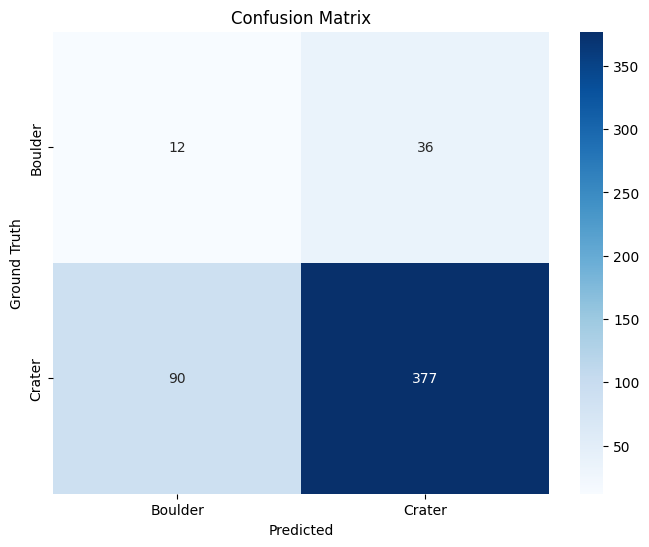

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(gt_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Boulder", "Crater"], yticklabels=["Boulder", "Crater"])
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

Validation AP from COCO (raw): 60.584
Validation AP (corrected to 0-1): 0.606
Validation AP array shape: (100,), first few values: [0.60584156 0.60584156 0.60584156 0.60584156 0.60584156]


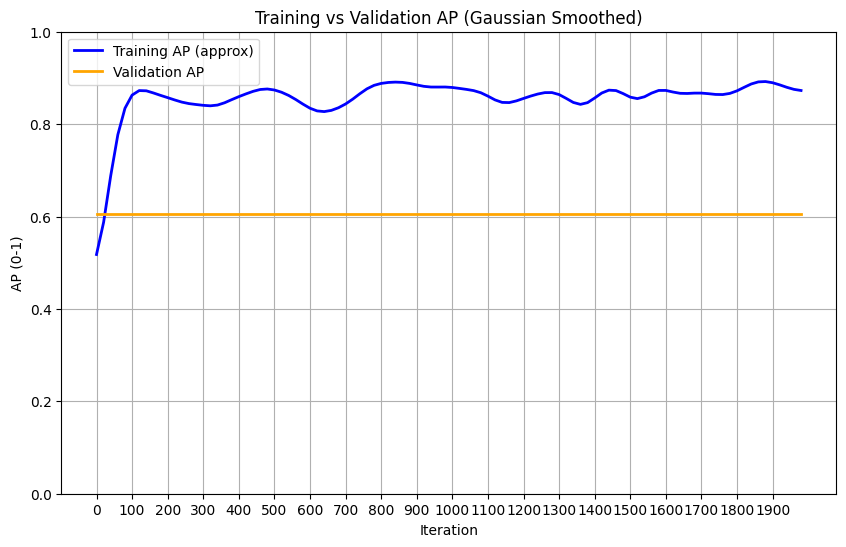

In [55]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

with open(os.path.join(cfg.OUTPUT_DIR, "training_history.pkl"), "rb") as f:
    history = pickle.load(f)

# Extract and subsample training AP approximation
total_loss = np.array(history["total_loss"])[:, 0]  # Take only the value
max_loss = max(total_loss) if max(total_loss) > 0 else 1e-6  # Avoid division by zero
train_ap_approx = 1 - total_loss / max_loss  # AP in 0-1 range
train_ap_approx = train_ap_approx[::20]  # Subsample to match iter (2000 -> 100)

# Validation AP (from COCO results, correct to 0-1 range)
coco_ap = results["bbox"]["AP"]
if coco_ap > 1:  # Assume percentage if > 1, convert to fraction
    val_ap = coco_ap / 100 * np.ones_like(train_ap_approx)
else:
    val_ap = coco_ap * np.ones_like(train_ap_approx)
print(f"Validation AP from COCO (raw): {results['bbox']['AP']:.3f}")
print(f"Validation AP (corrected to 0-1): {val_ap[0]:.3f}")
print(f"Validation AP array shape: {val_ap.shape}, first few values: {val_ap[:5]}")

# Apply Gaussian filter
train_ap_smooth = gaussian_filter1d(train_ap_approx, sigma=2)
val_ap_smooth = gaussian_filter1d(val_ap, sigma=2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(history["iter"], train_ap_smooth, label="Training AP (approx)", color="blue", linewidth=2)
plt.plot(history["iter"], val_ap_smooth, label="Validation AP", color="orange", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("AP (0-1)")  # Updated ylabel to reflect only AP
plt.title("Training vs Validation AP (Gaussian Smoothed)")
plt.legend()
plt.grid()
plt.ylim(0, 1)  # Force y-axis to 0-1 range
plt.xticks(history["iter"][::5])  # Show every 5th tick for clarity
plt.show()

WARNING [04/06 17:45:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/06 17:45:56 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/drive/MyDrive/Retinanetcoco_dataset/valid/_annotations_filtered.coco.json
Image 0: Type of losses = <class 'dict'>, Content = {'loss_cls': tensor(0.0610, device='cuda:0'), 'loss_box_reg': tensor(0.1087, device='cuda:0')}
Image 1: Type of losses = <class 'dict'>, Content = {'loss_cls': tensor(0.0720, device='cuda:0'), 'loss_box_reg': tensor(0.1137, device='cuda:0')}
Image 2: Type of losses = <class 'dict'>, Content = {'loss_cls': tensor(0.0645, device='cuda:0'), 'loss_box_reg': tensor(0.1083, device='cuda:0')}
Image 3: Type of losses = <class 'dict'>, Content = {'loss_cls': tensor(0.0648, device='cuda:0'), 'loss_box_reg': tensor(0.1005, device='cuda:0')}
Image 4: Type of losses = <class 'dict'>, Content = {'loss_cls': tensor(0.0587, device='cuda:0'), 'loss_box_reg': 

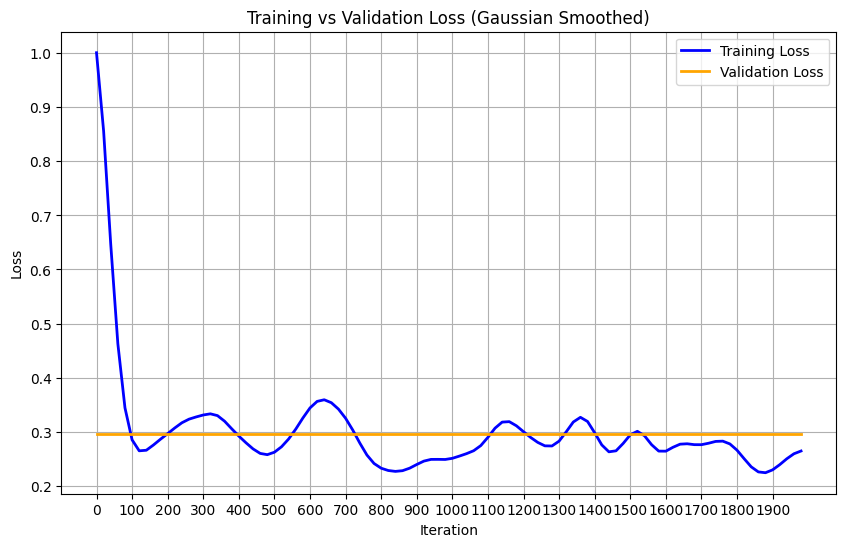

Average Validation Loss: 0.2950


In [52]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import torch
import cv2
from detectron2.structures import Instances, Boxes, BoxMode
from detectron2.utils.events import EventStorage

# Load training history
with open(os.path.join(cfg.OUTPUT_DIR, "training_history.pkl"), "rb") as f:
    history = pickle.load(f)

# Extract and subsample training loss
train_loss = np.array(history["total_loss"])[:, 0]  # Take only the value
train_loss = train_loss[::20]  # Subsample to match iter (2000 -> 100)

# Compute validation loss over the validation set with ground truth
dataset_dicts = DatasetCatalog.get("lunar_valid")
val_losses = []
trainer.model.train()  # Ensure training mode
for i, d in enumerate(dataset_dicts):
    img = cv2.imread(os.path.join(dataset_dir, "valid", d["file_name"]))
    # Prepare ground truth annotations
    gt_instances = []
    for ann in d["annotations"]:
        gt_instances.append({
            "category_id": ann["category_id"],
            "bbox": ann["bbox"],
            "bbox_mode": ann["bbox_mode"]
        })

    # Convert to Instances object
    height, width = img.shape[:2]
    instances = Instances(image_size=(height, width))
    if gt_instances:
        gt_boxes = [BoxMode.convert(ann["bbox"], ann["bbox_mode"], BoxMode.XYXY_ABS) for ann in gt_instances]
        instances.gt_boxes = Boxes(gt_boxes)
        instances.gt_classes = torch.tensor([ann["category_id"] for ann in gt_instances], dtype=torch.int64)
    else:
        instances.gt_boxes = Boxes([])
        instances.gt_classes = torch.tensor([], dtype=torch.int64)

    # Prepare input with ground truth
    inputs = [{
        "image": torch.as_tensor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float32").transpose(2, 0, 1)),
        "height": height,
        "width": width,
        "instances": instances
    }]

    with torch.no_grad():  # Disable gradients for efficiency
        with EventStorage() as storage:  # Provide EventStorage context
            losses = trainer.model(inputs)
            print(f"Image {i}: Type of losses = {type(losses)}, Content = {losses}")  # Debug output
            if isinstance(losses, dict):
                total_loss = sum(loss.item() for loss in losses.values())  # Sum dictionary losses
            elif isinstance(losses, list):
                total_loss = sum(loss.item() for loss in losses[0].values()) if losses else 0
            else:
                raise ValueError(f"Unexpected losses type: {type(losses)}")
            val_losses.append(total_loss)

val_loss = np.mean(val_losses) * np.ones_like(train_loss)  # Average loss as a constant array (fixed typo)

# Apply Gaussian filter
train_loss_smooth = gaussian_filter1d(train_loss, sigma=2)
val_loss_smooth = gaussian_filter1d(val_loss, sigma=2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(history["iter"], train_loss_smooth, label="Training Loss", color="blue", linewidth=2)
plt.plot(history["iter"], val_loss_smooth, label="Validation Loss", color="orange", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Gaussian Smoothed)")
plt.legend()
plt.grid()
plt.xticks(history["iter"][::5])  # Show every 5th tick for clarity
plt.show()

# Print summary for reference
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")